## **Projeto Final - Speech Recognition**

**Grupo 6 (Work4Data):**


*   Eduardo Moraes Coraça
*   Larissa Antonelli Santesso
*   José Renato Chiarini Pena Barbosa
*   William José Vicente

In [ ]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import librosa
import os
from os import listdir
from scipy import signal
from scipy.io import wavfile
import random
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!p7zip -d --keep 'gdrive/My Drive/MDC2020/speech/train.7z'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: gdrive/My Drive/MDC2020/speech/train.7z
--
Path = gdrive/My Drive/MDC2020/speech/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav                                                               0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                          

## **1. Funções Auxiliares**

In [ ]:
def importar_arquivos(df):
  # df: dataframe. Exemplo de linha: 'silence/youtube_3491.wav'
  # X: lista, cada linha e um array de audio
  # y: nome da classe. Ex: "one"
  X = []
  y = []
  for k in range(len(df)):
    path = 'train/audio/' + df.iloc[k].to_string(index=False).replace(' ','')
    y.append(df.iloc[k].to_string(index=False).split('/')[0].replace(' ',''))
    X.append(carregar_audio(path)[0])
    
  return X,y

In [ ]:
# Funcao para calculo do espectrograma utilizando LIBROSA
def convert_imagem_librosa(audio_array, output_shape, n_fft, window_size, hop_length, window, fs=1):
  # calculo do espectrograma

  spec = librosa.core.spectrum.stft(audio_array, 
                                  n_fft = n_fft,
                                  win_length = window_size,
                                  hop_length = hop_length,
                                  window=window)
  
  '''spec = librosa.feature.melspectrogram(audio_array, 
                                  n_fft = n_fft,
                                  hop_length = hop_length)
  '''
  spec_db = librosa.amplitude_to_db(abs(spec), ref=np.max)  # conversao para dB
  spec_db_norm = (spec_db - spec_db.min())/(spec_db.max()-spec_db.min())  # normalizando: valores entre 0 e 1
  spec_db_norm = (spec_db_norm - 0.5)*2
  
  im = Image.fromarray(np.uint8(cm.jet(spec_db_norm)*255))  # aplicando colormap
  rgb_image = im.convert('RGB') # convertento de RGBA para RGB
  #rgb_image = rgb_image[..., tf.newaxis]
  # retorna a imagem
  return (rgb_image.resize(output_shape))

In [ ]:
# Funcao para calculo do espectrograma utilizando SCIPY
def convert_imagem(audio, fs, output_shape, n_fft, window_size, hop_length, window):
  f,t,spec = signal.spectrogram(x=audio,
                     fs=fs,
                     window=window,
                     noverlap=window_size - hop_length,
                     nfft=n_fft,
                     mode='complex')
  
  spec_db = 20*np.log10(0.000001 + abs(spec)/abs(spec).max()) # convertendo para dB
  spec_db_norm = (spec_db-spec_db.min())/(spec_db.max() - spec_db.min()) # normalizando entre 0 e 1
  spec_db_norm = (spec_db_norm - 0.5)*2

  im = Image.fromarray(np.uint8(cm.jet(spec_db_norm)*255)) # calculando o colormap
    
  rgb_image = im.convert('RGB')
  return (rgb_image.resize(output_shape))

In [ ]:
# Funcao para importar audio utilizando SCIPY
def carregar_audio(path):
  fs, som = wavfile.read(path)
  return(np.array(som),fs)

In [ ]:
# Funcao para garantir que os audios tenham 1s
def audio_reshape(audio):
  tamanho = len(audio[0])
 #tamanho_final = audio[1]
  tamanho_final = 16000
  if tamanho == tamanho_final:
    return audio
  elif tamanho < tamanho_final: # completar com zeros
    return (np.concatenate((audio[0], np.zeros(tamanho_final-tamanho))),tamanho_final)
  elif tamanho > tamanho_final: # remove os primeiros elementos
    return (audio[0][tamanho-tamanho_final:], tamanho_final)

In [ ]:
# Funcao para dividir os audios '_background_noise_' em trechos de 1s e salvar na pasta especificada
def background_noise_split(audio, final_shape, nome, path):
  tamanho = len(audio[0])
  fs = audio[1] # frequencia de amostragem (amostras/s)
  for cont in range(0,tamanho//final_shape,1):
    audio_split = audio[0][cont*final_shape : (cont+1)*final_shape]
    #librosa.output.write_wav('gdrive/My Drive/MDC2020/speech/train/audio/silence/'+nome+'_'+str(cont)+'.wav',audio_split, fs)
    librosa.output.write_wav(path+nome+'_'+str(cont)+'.wav',audio_split, fs)

In [ ]:
# Funcao para plotar os histogramas contendo a quantidade de classes dos dados
def plot_histogram(my_df, dsrd_column, x_size, y_size, class_dict):
  import seaborn as sns
  sns.set(font_scale=1.5)
  
  # Criando data frames que serão utilizados para plotar o número de classes
  class_dict_reduced = {0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'off', 5: 'on', 6: 'right', 7: 'silence', 8: 'stop', 9: 'up', 10: 'yes', 11: 'unknown'}
  #class_dict_reduced = {'down':0, 'go':1, 'left':2, 'no':3, 'off':4, 'on':5, 'right':6, 'silence':7, 'stop':8, 'up':9, 'yes':10, 'unknown':11}

  plot_df = pd.DataFrame(my_df.str[0].to_numpy(), columns=['Class'])
  plot_df['Class_number'] = plot_df['Class'].apply(map_values, args = (class_dict,))
  plot_df['New Class'] = plot_df['Class_number'].apply(map_values, args = (class_dict_reduced,))
    
  f, ax = plt.subplots(figsize=(x_size, y_size))
  ax = sns.countplot(x=dsrd_column, data=plot_df, palette="GnBu_d")
  plt.xlabel('Classe')
  plt.ylabel('Quantidade de Amostras')
  sns.despine()
  plt.show()

In [ ]:
# Funcao para mapear o dicionario
def map_values(row, values_dict):
    return values_dict[row]

In [ ]:
# função para avaliar o modelo treinado a partir de metricas e da matriz de confusao
def avaliar_modelo(modelo, gerador, normalizado=True, num_classes=12):
  from sklearn import metrics
  import itertools

  y_true = np.array(gerador.get_labels())
  y_pred = np.argmax(modelo.predict(gerador), axis=1)

  # calculo da matriz de confusao
  cm = confusion_matrix(y_true, y_pred)
  cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True) # normalizada

  # calculo das metricas
  balanced_acc = np.trace(cmn) / num_classes # acuracia balanceada
  acc = metrics.accuracy_score(y_true, y_pred) # acuracia
  print('Balanced Accuracy: '+str(round(balanced_acc,4)))
  print('Accuracy: '+str(round(acc,4)))

  #plotando
  plt.style.use('default') 
  if normalizado == True:
    plt.figure(figsize=(12,6))
    plt.imshow(cmn, cmap=plt.cm.Blues)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    thresh = cmn.max() / 2.
    for i, j in itertools.product(range(cmn.shape[0]), range(cmn.shape[1])):
      plt.text(j, i, round(cmn[i, j],2),
              horizontalalignment="center",
              color="white" if cmn[i, j] > thresh else "black")
    plt.tight_layout
  else:
    plt.figure(figsize=(12,6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, round(cm[i, j],2),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout

In [ ]:
# funcao para converter audio de stereo para mono
def stereo2mono(som):
  length = som.shape[0]
  mono = (som[0:length:1, 0]+som[0:length:1, 1])/2
  return(mono)

In [ ]:
# Funcao para gerar um data frame, a ser convertido para .csv e submetido no Kaggle
def gerar_csv_kaggle(modelo, test_path, class_dict, threshold=0.4):
  import pandas as pd
  test_files = listdir(test_path)
  fname=[]
  label=[]
  i=0
  for amostra_teste in test_files:
    if i%1000 == 0:
      print(i)
    
    audio = carregar_audio(test_path + amostra_teste)
    img = convert_imagem(audio=audio[0], fs=audio[1], output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)
    img = np.array(img)*(1./255)
    img_arr = img[np.newaxis,:]
    y_softmax = modelo.predict(img_arr) 
    y_pred = np.argmax(y_softmax, axis=1)
    if y_softmax[0][y_pred] < threshold:
      y_pred = 7 # prediz como silence
    for classe,num in class_dict.items():
      if y_pred == num:
        label.append(classe)
        break
    fname.append(amostra_teste)
    i+=1

  data = {'fname':fname, 'label':label}
  return pd.DataFrame(data)

In [ ]:
# função para avaliar o modelo treinado a partir de metricas e da matriz de confusao
def avaliar_modelo_threshold(modelo, gerador, normalizado=True, num_classes=12, threshold=0.5):
  from sklearn import metrics
  import itertools

  y_true = np.array(gerador.get_labels())
  y_softmax = modelo.predict(gerador)
  y_pred = np.argmax(y_softmax, axis=1)

  for i in range(0,len(y_pred)):
   if y_softmax[i,][y_pred[i]] < threshold:
      y_pred[i] = 7 # prediz como silence

  # calculo da matriz de confusao
  cm = confusion_matrix(y_true, y_pred)
  cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True) # normalizada

  # calculo das metricas
  balanced_acc = np.trace(cmn) / num_classes # acuracia balanceada
  acc = metrics.accuracy_score(y_true, y_pred) # acuracia
  print('Balanced Accuracy: '+str(round(balanced_acc,4)))
  print('Accuracy: '+str(round(acc,4)))

  #plotando
  plt.style.use('default') 
  if normalizado == True:
    plt.figure(figsize=(12,6))
    plt.imshow(cmn, cmap=plt.cm.Blues)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    thresh = cmn.max() / 2.
    for i, j in itertools.product(range(cmn.shape[0]), range(cmn.shape[1])):
      plt.text(j, i, round(cmn[i, j],2),
              horizontalalignment="center",
              color="white" if cmn[i, j] > thresh else "black")
    plt.tight_layout
  else:
    plt.figure(figsize=(12,6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, round(cm[i, j],2),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout

Função para aumentação de áudio utilizando a biblioteca Librosa:

In [ ]:
def aumentar_audio(audio, time_stretch = (False, 1), pitch_shift = (False, 1), noise = (False, 0.01)):
  audio_aug = audio
  if time_stretch[0] == True: # aplica stretch no sinal
    audio_aug = librosa.effects.time_stretch(audio_aug.astype('float64'), time_stretch[1])

  if pitch_shift[0] == True: # aplica translacao no sinal
    audio_aug = librosa.effects.pitch_shift(audio_aug.astype('float64'), sr=16000, n_steps=pitch_shift[1])

  if noise[0] == True: # insere ruido aleatorio (segundo distribuicao normal) no sinal
    ampl = noise[1]*np.max(audio_aug)
    audio_aug = audio_aug.astype('float64') + ampl*np.random.normal(size = audio_aug.shape[0])

  return audio_aug

## **2. Criando exemplos de Silêncio**

Lista de arquivos no diretório '_background_noise_'.

O arquivo 'youtube_sample' foi baixado do YouTube. (Ontiva.com_One_Hour_of_HQ_Coffee_Shop_Background_Noise)

In [ ]:
# background noise original
background_noise = ['white_noise.wav', 'running_tap.wav', 'pink_noise.wav', 'exercise_bike.wav', 'dude_miaowing.wav', 'doing_the_dishes.wav']

Carregando os arquivos de silêncio. Os arquivos baixados do YouTube são separados dos originais em pastas diferentes.

In [ ]:
os.mkdir('train/audio/silence_youtube')

In [ ]:
#o arquivo do youtube deve ser convertido para formato Mono antes do split

#youtube_audio, youtube_fs = carregar_audio('gdrive/My Drive/MDC2020/speech/train/audio/_background_noise_/youtube_sample.wav')
youtube_audio, youtube_fs = librosa.load('gdrive/My Drive/MDC2020/speech/train/audio/_background_noise_/youtube_sample.wav', sr=16000) # aqui a funcao do Librosa e utilizada pois, com ela, e possivel re-amostrar na taxa de 16000 samples/s, igual aos outros audios

background_noise_split(#audio = [stereo2mono(youtube_audio),youtube_fs],
                       audio=[youtube_audio,youtube_fs],
                       final_shape = youtube_fs,
                       nome = 'youtube',
                       path='train/audio/silence_youtube/')   

youtube_silence_files= listdir('train/audio/silence_youtube/')        

In [ ]:
os.mkdir('train/audio/silence_original')

In [ ]:
for noise in background_noise:
  background_noise_split(audio = librosa.load('train/audio/_background_noise_/'+noise, sr = 16000, mono = False),
                         final_shape = 16000,
                         nome = noise.split('.')[0],
                         path='train/audio/silence_original/')    

Diretório contendo todos os arquivos juntos

In [ ]:
os.mkdir('train/audio/silence')

In [ ]:
youtube_audio, youtube_fs = carregar_audio('gdrive/My Drive/MDC2020/speech/train/audio/_background_noise_/youtube_sample.wav')

background_noise_split(audio = [stereo2mono(youtube_audio),youtube_fs],
                       final_shape = youtube_fs,
                       nome = 'youtube',
                       path='train/audio/silence/')   

for noise in background_noise:
  background_noise_split(audio = librosa.load('train/audio/_background_noise_/'+noise, sr = 16000, mono = False),
                         final_shape = 16000,
                         nome = noise.split('.')[0],
                         path='train/audio/silence/') 

## **3. Importando os Arquivos**

Importando os arquivos .txt

In [ ]:
validation_list = pd.read_csv('gdrive/My Drive/MDC2020/speech/train/' + 'validation_list.txt', sep=' ', header=None)
train_list = pd.read_csv('gdrive/My Drive/MDC2020/speech/train/' + 'train_list.txt', sep=' ', header=None)
test_list = pd.read_csv('gdrive/My Drive/MDC2020/speech/train/' + 'testing_list.txt', sep=' ', header=None)

In [ ]:
print('Validation: '+str(len(validation_list)))
print('Train: '+ str(len(train_list)))
print('Test: '+str(len(test_list)))

Validation: 6798
Train: 51088
Test: 6835


Criando a lista de arquivos silence com os arquivos Background Noise originais:

In [ ]:
from sklearn.model_selection import train_test_split

youtube_silence_files = listdir('train/audio/silence_youtube/')
original_silence_files = listdir('train/audio/silence_original/')

youtube_silence_files = ['silence/' + s for s in youtube_silence_files]
original_silence_files = ['silence/' + s for s in original_silence_files]

# arquivos de silence sao divididos aleatoriamente

silence_train, silence_val_test = train_test_split(original_silence_files, train_size = 0.7, test_size = 0.3)
silence_test, silence_val = train_test_split(silence_val_test, train_size = 0.5, test_size = 0.5)

# desta forma, teremos, para o Silence, 70% no treino, 15% na validacao e 15% no teste

train_list_silence_original = pd.concat([train_list, pd.DataFrame(silence_train)], ignore_index=True)
validation_list_silence_original = pd.concat([validation_list, pd.DataFrame(silence_val)], ignore_index=True)
test_list_silence_original = pd.concat([test_list, pd.DataFrame(silence_test)], ignore_index=True)

Criando a lista de arquivos Silence com o áudio baixado do YouTube, o qual será utilizado no treinamento:

In [ ]:
from sklearn.model_selection import train_test_split

youtube_silence_files = listdir('train/audio/silence_youtube/')
original_silence_files = listdir('train/audio/silence_original/')

youtube_silence_files = ['silence/' + s for s in youtube_silence_files]
original_silence_files = ['silence/' + s for s in original_silence_files]

# arquivos do YouTube -> conjunto de treino
# demais arquivos -> split em validação e teste

silence_train = youtube_silence_files
silence_val, silence_test = train_test_split(original_silence_files, train_size = 0.5, test_size = 0.5)

train_list = pd.concat([train_list, pd.DataFrame(silence_train)], ignore_index=True)
validation_list = pd.concat([validation_list, pd.DataFrame(silence_val)], ignore_index=True)
test_list = pd.concat([test_list, pd.DataFrame(silence_test)], ignore_index=True)

Tamanhos após adicionar silêncio:

In [ ]:
print('Validation (com dados do YouTube): ' + str(len(validation_list)))
print('Train (com dados do YouTube): ' + str(len(train_list)))
print('Test (com dados do YouTube): ' + str(len(test_list)))

Validation (com dados do YouTube): 6997
Train (com dados do YouTube): 54718
Test (com dados do YouTube): 7034


In [ ]:
print('Validation (silence original): ' + str(len(validation_list_silence_original)))
print('Train (silence original): ' + str(len(train_list_silence_original)))
print('Test (silence original): ' + str(len(test_list_silence_original)))

Validation (silence original): 6858
Train (silence original): 51366
Test (silence original): 6895


### 3.1 Importando através das listas

In [ ]:
X_train, y_train = importar_arquivos(train_list)
X_val, y_val = importar_arquivos(validation_list)
X_test, y_test = importar_arquivos(test_list)

X_train_original, y_train_original = importar_arquivos(train_list_silence_original)
X_val_original, y_val_original = importar_arquivos(validation_list_silence_original)
X_test_original, y_test_original = importar_arquivos(test_list_silence_original)

## **4. Criando dicionários de classes**

Criando uma lista contendo *(label, nome_arquivo)*, o que é utilizado como input da classe **Gerador**. Serão criados dois conjuntos de listas de Treino, Validação e Teste: uma para o silence original e outra para o silence do YouTube.

In [ ]:
validation_label_nome = validation_list[0].str.split('/')
train_label_nome = train_list[0].str.split('/')
test_label_nome = test_list[0].str.split('/')

In [ ]:
validation_label_nome_original = validation_list_silence_original[0].str.split('/')
train_label_nome_original = train_list_silence_original[0].str.split('/')
test_label_nome_original = test_list_silence_original[0].str.split('/')

In [ ]:
# Diminuindo para 12 classes (enunciado Kaggle)
kaggle_list = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]

# Dicionario
class_list = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'silence', 'six', 'stop', 'three',
              'tree', 'two', 'up', 'wow', 'yes', 'zero']
num = 0
class_dict = {}
for classe in class_list:
  if classe != '_background_noise_':
    if classe in kaggle_list:
      class_dict[classe] = num
      num+=1
    else:
      class_dict[classe] = 11 # others outside of the list are unknown
      
class_dict

{'bed': 11,
 'bird': 11,
 'cat': 11,
 'dog': 11,
 'down': 0,
 'eight': 11,
 'five': 11,
 'four': 11,
 'go': 1,
 'happy': 11,
 'house': 11,
 'left': 2,
 'marvin': 11,
 'nine': 11,
 'no': 3,
 'off': 4,
 'on': 5,
 'one': 11,
 'right': 6,
 'seven': 11,
 'sheila': 11,
 'silence': 7,
 'six': 11,
 'stop': 8,
 'three': 11,
 'tree': 11,
 'two': 11,
 'up': 9,
 'wow': 11,
 'yes': 10,
 'zero': 11}

## **4. Avaliando o número de amostras e balanceamento**

Avaliando graficamente a distribuição das 30 classes originais no conjunto de treino:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


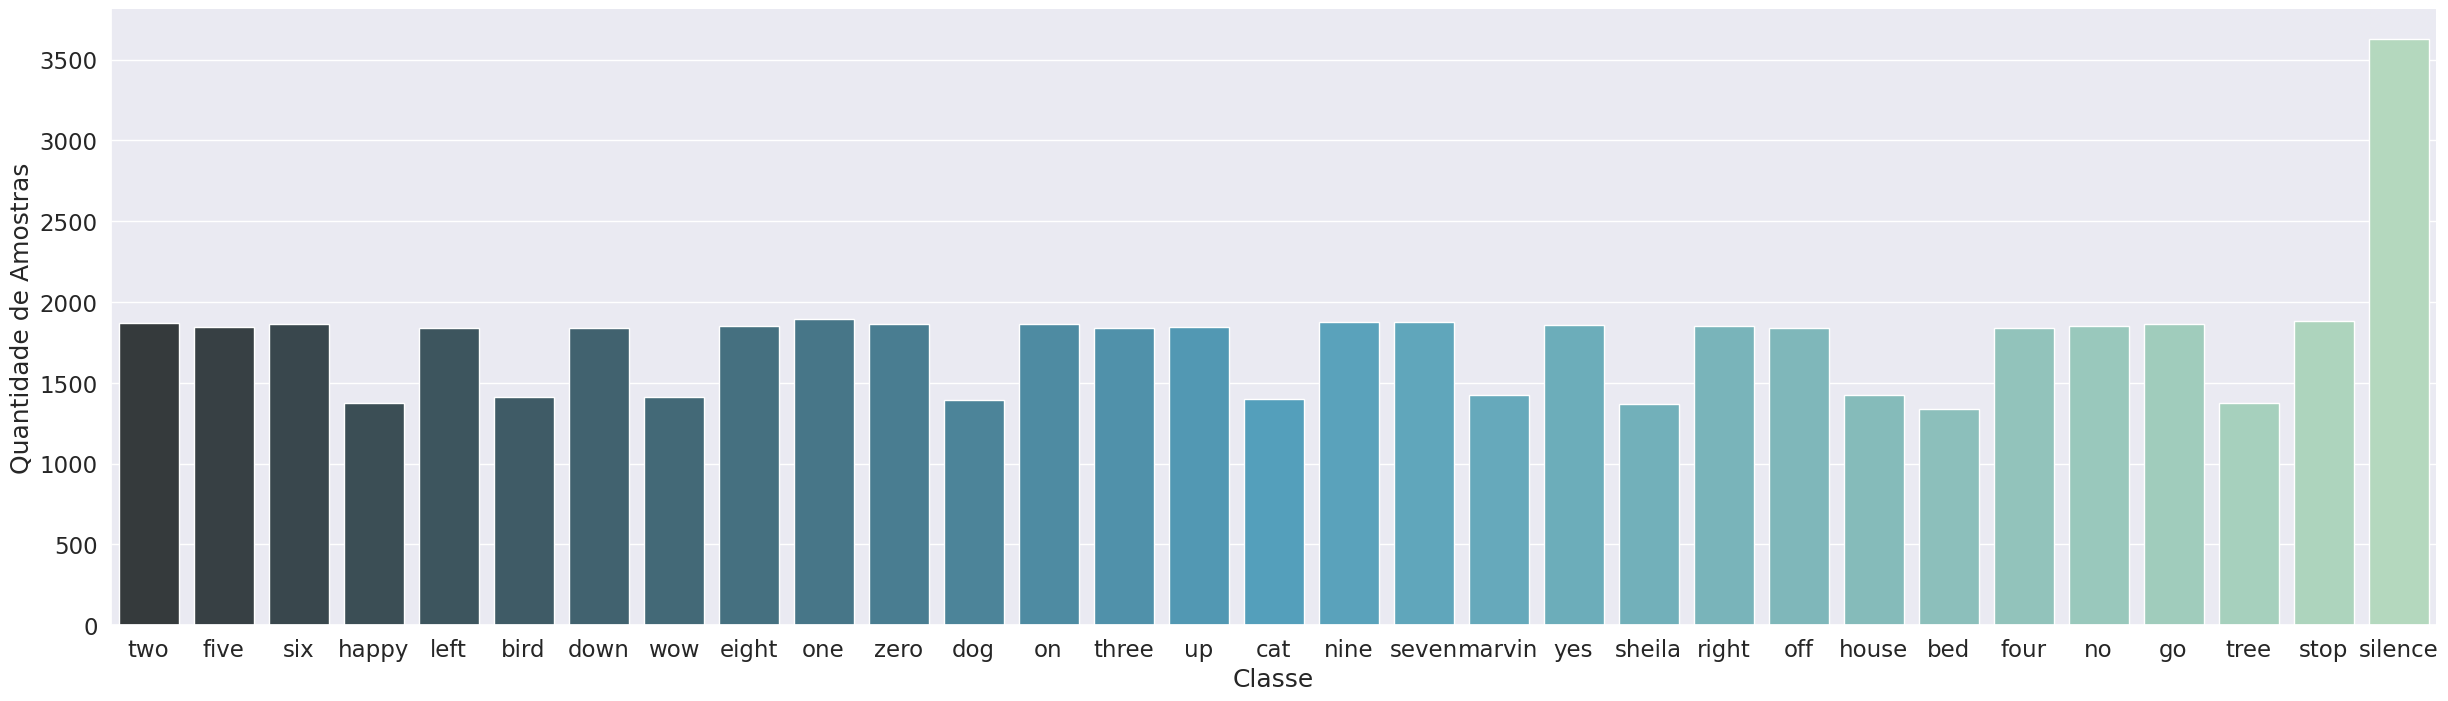

In [ ]:
plot_histogram(my_df=train_label_nome, dsrd_column='Class', x_size=30, y_size=8, class_dict=class_dict)

Avaliando graficamente a distribuição das 12 classes no conjunto de treino:

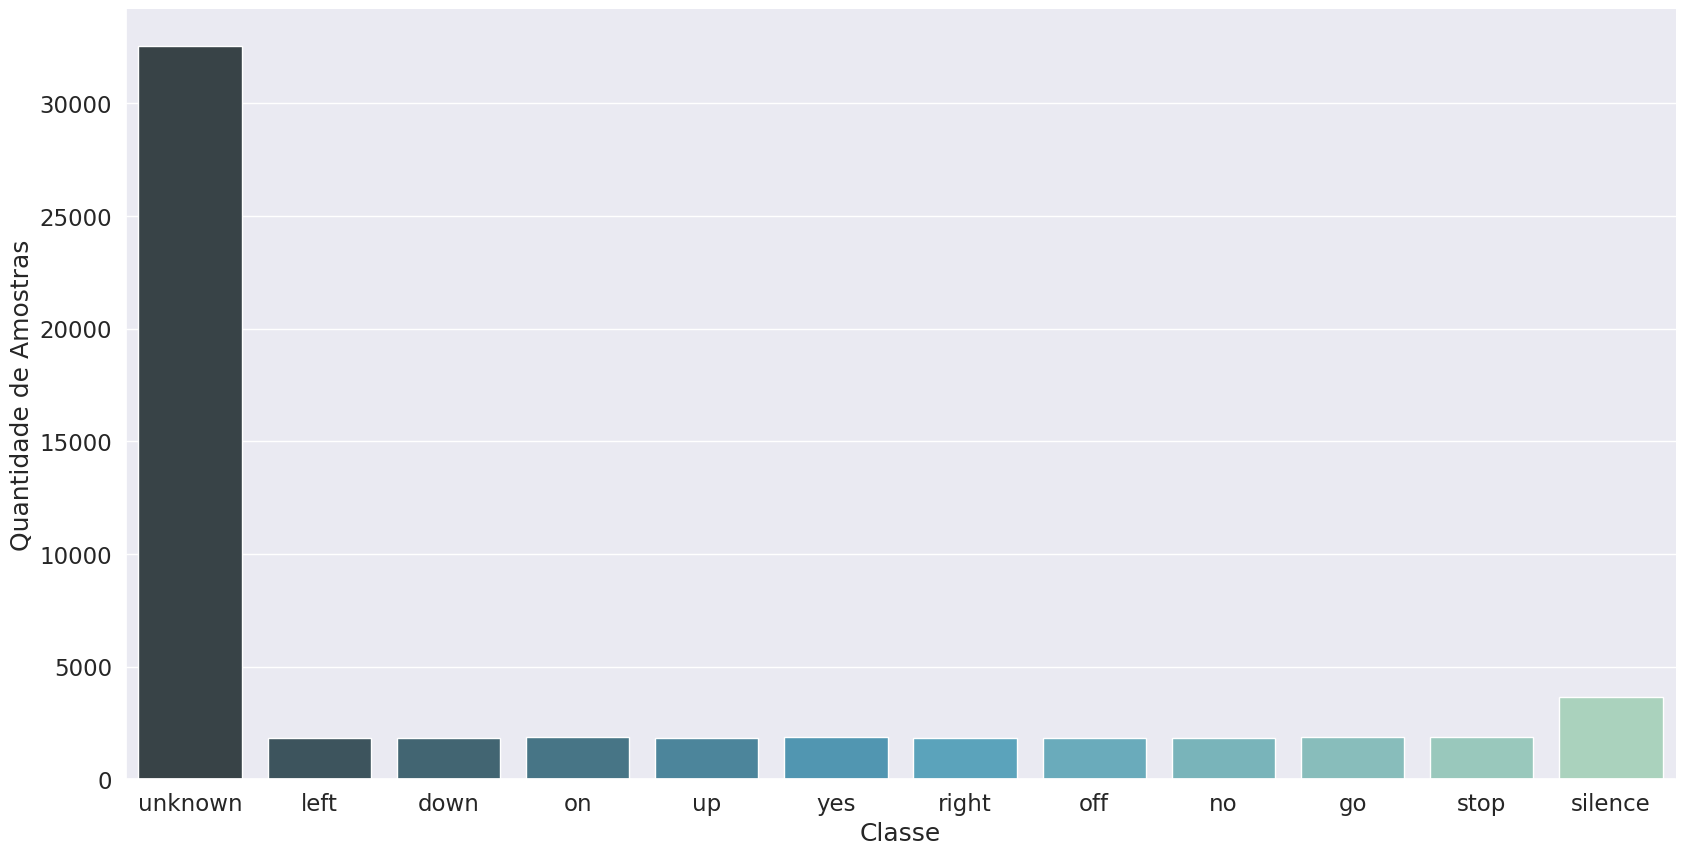

In [ ]:
plot_histogram(my_df=train_label_nome, dsrd_column='New Class', x_size=20, y_size=10, class_dict=class_dict)

Como as classes estão desbalanceadas, serão utilizados pesos no treinamento. Estes pesos são calculados abaixo:

In [ ]:
from sklearn.utils import class_weight

class_dict_reduced = {0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'off', 5: 'on', 6: 'right', 7: 'stop', 8: 'up', 9: 'yes', 10: 'silence', 11: 'unknown'}

train_df = pd.DataFrame(train_label_nome.str[0].to_numpy(), columns=['Class'])
train_df['Class_number'] = train_df['Class'].apply(map_values, args = (class_dict,))
train_df['New Class'] = train_df['Class_number'].apply(map_values, args = (class_dict_reduced,))

arr_class_weights = class_weight.compute_class_weight(
                    'balanced',
                    np.unique(train_df['Class_number']),
                    np.array(train_df['Class_number']))

class_weights = dict(enumerate(arr_class_weights))
print(class_weights)

{0: 2.4754795512124503, 1: 2.4502059824467133, 2: 2.4795178539061085, 3: 2.4607843137254903, 4: 2.4795178539061085, 5: 2.4462625178826896, 6: 2.462113030957523, 7: 1.2561524334251608, 8: 2.4190097259062777, 9: 2.4741363718574787, 10: 2.4515232974910393, 11: 0.14008704557091653}


## **5. Avaliando o espectrograma e as possíveis aumentações**

Nesta seção, a conversão de áudio para imagem é explórada através do espectrograma, bem como a aplicação de aumentação nos sinais.

### 5.1 Exemplo de Espectrograma

Parâmetros do espectrograma (serão utilizados em todos as funções seguintes)

In [ ]:
fs = 16000
window_size = 256
n_fft = 512
hop_length = 32
window = np.hanning(window_size)
output_shape=(128,128) # dimensao da imagem gerada
n_channel = 3
(L,W) = output_shape
num_classes = 12

Gerando um exemplo de espectrograma de áudio

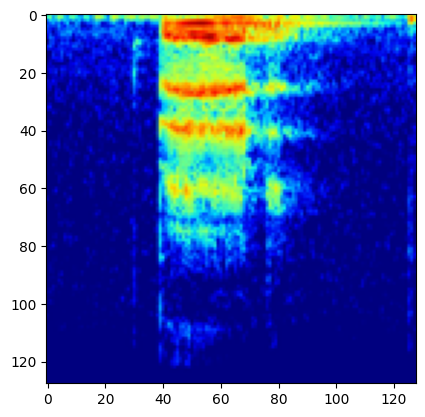

In [ ]:
path_example = 'gdrive/My Drive/MDC2020/speech/train/audio/'+validation_list[0].str.split('/')[0][0]+'/'+validation_list[0].str.split('/')[0][1]
audio_exemplo = carregar_audio(path_example)
img_exemplo = convert_imagem(audio=audio_exemplo[0], fs=audio_exemplo[1], output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)
plt.style.use('default') 
plt.imshow(img_exemplo)

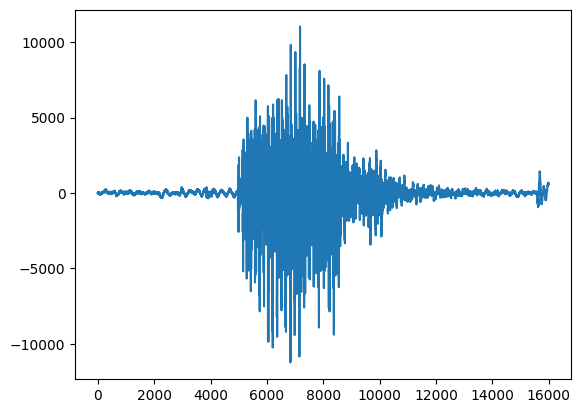

In [ ]:
plt.plot(audio_exemplo[0])

### 5.2 Exemplos de aumentação

*Time stretch*

<function matplotlib.pyplot.tight_layout>

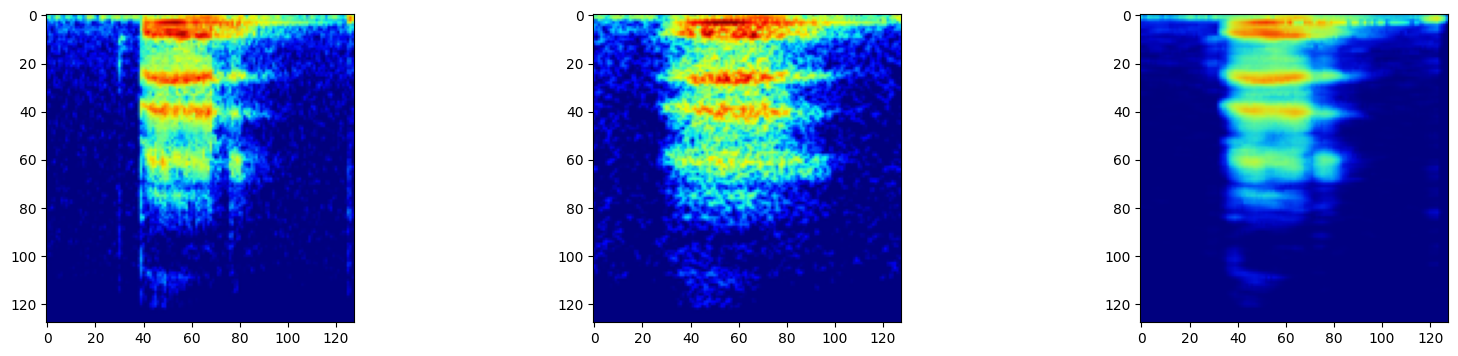

In [ ]:
audio_stretch = aumentar_audio(audio_exemplo[0],
                             time_stretch = (True, 3))

img_stretch1 = convert_imagem(audio = aumentar_audio(audio_exemplo[0], time_stretch = (True, 2)), 
                             fs=16000, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

img_stretch2 = convert_imagem(audio = aumentar_audio(audio_exemplo[0], time_stretch = (True, 0.01)), 
                             fs=16000, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.imshow(img_exemplo)
plt.subplot(1,3,2)
plt.imshow(img_stretch1)
plt.subplot(1,3,3)
plt.imshow(img_stretch2)
plt.tight_layout

Ruído aleatório com distribuição normal

<function matplotlib.pyplot.tight_layout>

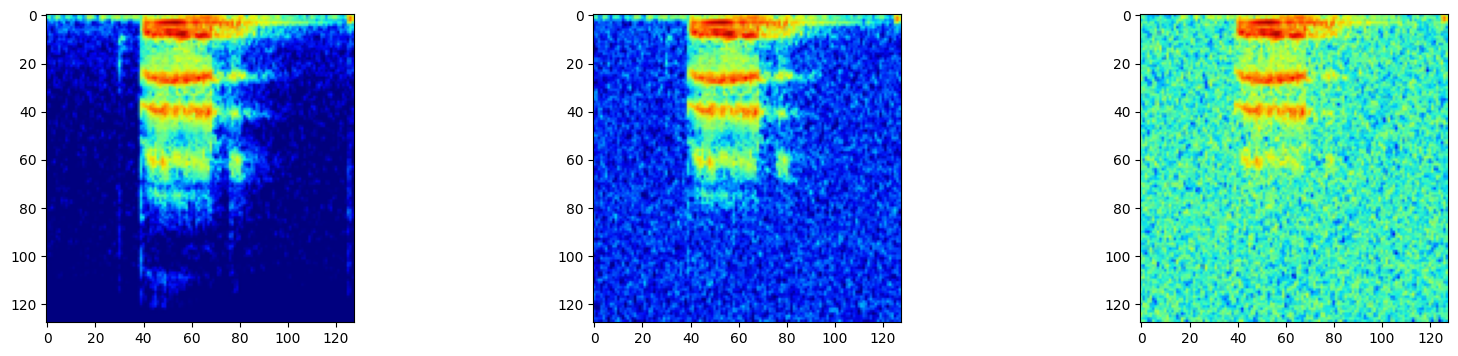

In [ ]:
audio_noise = aumentar_audio(audio_exemplo[0], noise = (True, 0.01))

img_noise1 = convert_imagem(audio=aumentar_audio(audio_exemplo[0], noise = (True, 0.01)),
                           fs=16000, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

img_noise2 = convert_imagem(audio=aumentar_audio(audio_exemplo[0], noise = (True, 0.05)),
                           fs=16000, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.imshow(img_exemplo)
plt.subplot(1,3,2)
plt.imshow(img_noise1)
plt.subplot(1,3,3)
plt.imshow(img_noise2)
plt.tight_layout

Alteração de *pitch*

<function matplotlib.pyplot.tight_layout>

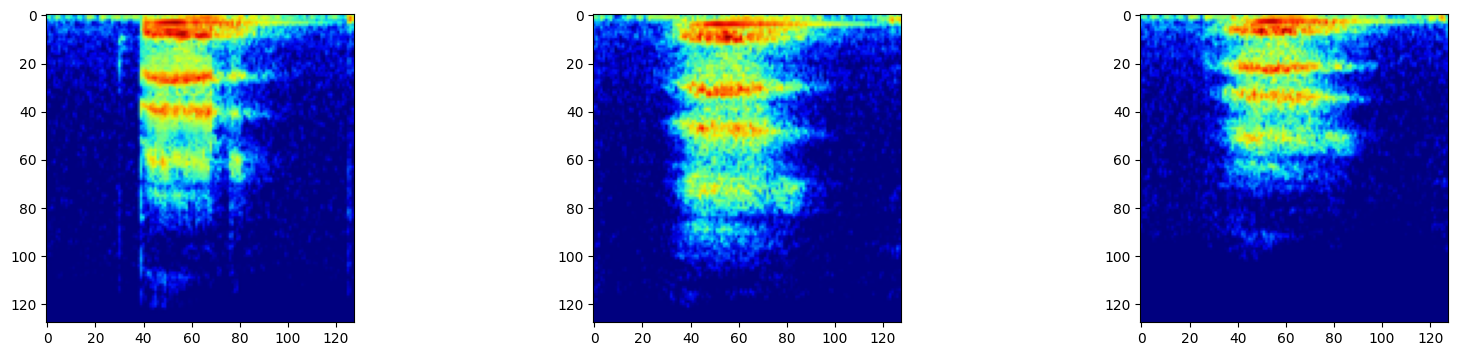

In [ ]:
img_pitch1 = convert_imagem(audio=aumentar_audio(audio_exemplo[0], pitch_shift = (True, 3)),
                           fs=16000, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

img_pitch2 = convert_imagem(audio=aumentar_audio(audio_exemplo[0], pitch_shift = (True, -3)),
                           fs=16000, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.imshow(img_exemplo)
plt.subplot(1,3,2)
plt.imshow(img_pitch1)
plt.subplot(1,3,3)
plt.imshow(img_pitch2)
plt.tight_layout

### 5.3 Visualização de Silence

In [ ]:
ex_sil_orig1 = convert_imagem(carregar_audio('train/audio/silence_original/dude_miaowing_1.wav')[0], fs=fs, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)
ex_sil_orig2 = convert_imagem(carregar_audio('train/audio/silence_original/doing_the_dishes_1.wav')[0], fs=fs, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)
ex_sil_orig3 = convert_imagem(carregar_audio('train/audio/silence_original/running_tap_1.wav')[0], fs=fs, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

ex_sil_yt = convert_imagem(carregar_audio('train/audio/silence_youtube/youtube_100.wav')[0], fs=fs, output_shape=output_shape, n_fft=n_fft, window_size=window_size, hop_length=hop_length, window=window)

Exemplos: 3 trechos originais + 1 treho do YouTube.

<function matplotlib.pyplot.tight_layout>

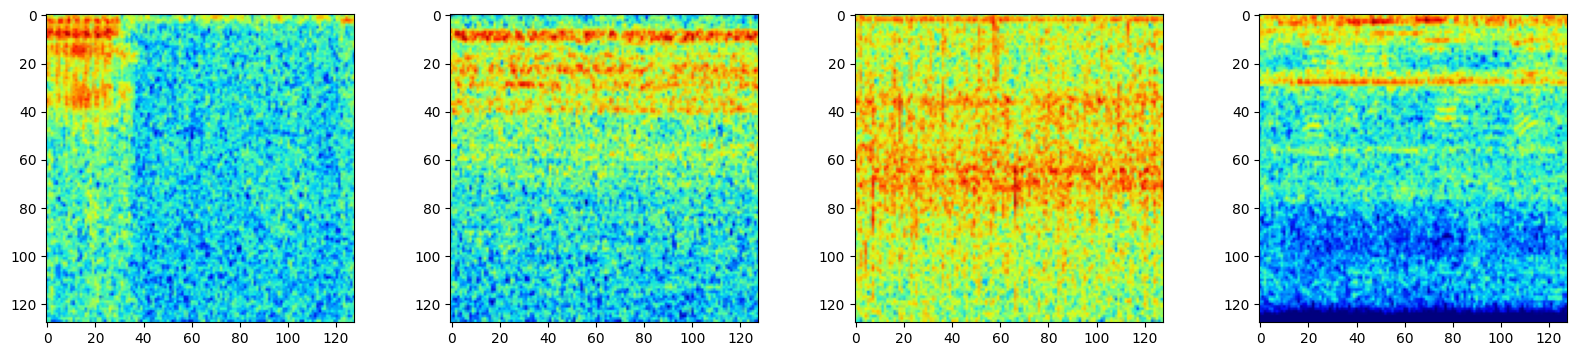

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.imshow(ex_sil_orig1)
plt.subplot(1,4,2)
plt.imshow(ex_sil_orig2)
plt.subplot(1,4,3)
plt.imshow(ex_sil_orig3)
plt.subplot(1,4,4)
plt.imshow(ex_sil_yt)
plt.tight_layout

## **6. Criando os Geradores**

### 6.1 Classe 'Gerador'

Criando a classe **Gerador** para gerar as imagens a partir do áudio.

Fonte: [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [ ]:
class Gerador(tf.keras.utils.Sequence): 
  def __init__(self, output_shape, X, y, class_dict, path, fs, batch_size, n_channels, n_classes, shuffle, n_fft, window_size, hop_length, window, augment):
      # inicializacao
      self.fs = fs
      self.X = X
      self.y = y
      self.output_shape = output_shape
      self.path = path
      self.batch_size = batch_size
      self.n_channels = n_channels
      self.n_classes = n_classes
      self.shuffle = shuffle
      self.n_fft = n_fft
      self.window_size = window_size
      self.hop_length = hop_length
      self.window = window
      self.class_dict = class_dict

      # Variaveis de aumentacao:
      self.augment = augment # booleano, True: aplica aumentacao

      self.on_epoch_end()
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def get_labels(self):
    return np.vectorize(class_dict.get)(self.y[0 : self.batch_size*(len(self.y)//self.batch_size)])
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def on_epoch_end(self):
    # criacao dos índices da proxima epoca (com ou sem schuffle)
    self.indexes = np.arange(len(self.y))
    
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
    
    if self.augment == True:
      import random
      self.pitch_augm = random.randint(-300,300)/100 # numero aleatorio entre -3 e 3
      self.time_augm = random.randint(1,200)/100 # numero aleatorio entre 0 e 1
      self.noise_augm = random.randint(1,2)/100 # numero aleatorio entre 0 e 0.02
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def __data_generation(self, X_batch, y_batch):
    # metodo para geracao de batches
    X = np.empty((self.batch_size, *self.output_shape, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)   # labels

    # gerando os dados
    for i in range(len(y_batch)):
      audio_array = X_batch[i]

      if self.augment == True:
        audio_array = aumentar_audio(audio = audio_array, time_stretch = (True, self.time_augm), pitch_shift = (False, self.pitch_augm), noise = (True, self.noise_augm)) # aplicar aumentacao no array
      
      X[i,] = convert_imagem(audio=audio_array, fs=self.fs,output_shape=self.output_shape, n_fft=self.n_fft, window_size=self.window_size, hop_length=self.hop_length, window=self.window)
      y[i] = self.class_dict[y_batch[i]]

    # utilizando to_categorical para fazer one-hot-encoding
    return X*(1./255), tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def __len__(self):
    # numero de batches por epoca
    return int(np.floor(len(self.y)/self.batch_size))
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def __getitem__(self, index):
    # metodo para gerar um batch
    # gerando indices do batch. Exemplo: [1,2,3,4,5], batch = 2 -> [1,2] em index=0, [3,4] em index=1, etc
    indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size] # gerando os indices
    # gerando lista de label-nome do batch
    X_batch = [self.X[k] for k in indexes]
    y_batch = [self.y[k] for k in indexes]

    # gerando os  dados
    X,y = self.__data_generation(X_batch, y_batch)
    
    return X,y

### 6.2 Instanciando os geradores

Serão instanciados 3 tipos de geradores para Treino, Validação e Teste:


1.   **Gerador 1**: conjunto Silence original + sem aumentação
2.   **Gerador 2**: conjunto Silence YouTube + sem aumentação 
3.   **Gerador 3**: conjunto Silence YouTube + com aumentação 

**Gerador 1** (conjunto Silence original + sem aumentação):

In [ ]:
train_generator_1 = Gerador(X=X_train_original,
                            y=y_train_original,
                            batch_size=32,
                            output_shape=output_shape,
                            n_fft=n_fft,
                            window=window,
                            window_size=window_size,
                            hop_length=hop_length,
                            fs=fs,
                            path = 'train/audio/',
                            class_dict=class_dict,
                            n_classes=num_classes,
                            n_channels=n_channel,
                            shuffle = True,
                            augment = False)
validation_generator_1 = Gerador(X=X_val_original,
                                 y=y_val_original,
                                 batch_size = 32,
                                 output_shape = output_shape,
                                 n_fft = n_fft,
                                 window = window,
                                 window_size = window_size,
                                 hop_length = hop_length,
                                 fs = fs,
                                 path= 'train/audio/',
                                 class_dict = class_dict,
                                 n_channels = n_channel,
                                 n_classes = num_classes, 
                                 shuffle = False,
                                 augment = False)
test_generator_1 = Gerador(X=X_test_original,
                           y=y_test_original,
                           batch_size = 32,
                           output_shape = output_shape,
                           n_fft = n_fft,
                           window = window,
                           window_size = window_size,
                           hop_length = hop_length,
                           fs = fs,
                           path= 'train/audio/',
                           class_dict = class_dict,
                           n_channels = n_channel,
                           n_classes = num_classes, 
                           shuffle = False,
                           augment = False)

**Gerador 2** (conjunto Silence YouTube + sem aumentação):

In [ ]:
train_generator_2 = Gerador(X=X_train,
                            y=y_train,
                            batch_size=32,
                            output_shape=output_shape,
                            n_fft=n_fft,
                            window=window,
                            window_size=window_size,
                            hop_length=hop_length,
                            fs=fs,
                            path = 'train/audio/',
                            class_dict=class_dict,
                            n_classes=num_classes,
                            n_channels=n_channel,
                            shuffle = True,
                            augment = False)
validation_generator_2 = Gerador(X=X_val,
                                 y=y_val,
                                 batch_size = 32,
                                 output_shape = output_shape,
                                 n_fft = n_fft,
                                 window = window,
                                 window_size = window_size,
                                 hop_length = hop_length,
                                 fs = fs,
                                 path= 'train/audio/',
                                 class_dict = class_dict,
                                 n_channels = n_channel,
                                 n_classes = num_classes, 
                                 shuffle = False,
                                 augment = False)
test_generator_2 = Gerador(X=X_test,
                           y=y_test,
                           batch_size = 32,
                           output_shape = output_shape,
                           n_fft = n_fft,
                           window = window,
                           window_size = window_size,
                           hop_length = hop_length,
                           fs = fs,
                           path= 'train/audio/',
                           class_dict = class_dict,
                           n_channels = n_channel,
                           n_classes = num_classes, 
                           shuffle = False,
                           augment = False)

Gerador 3 (conjunto Silence YouTube + com aumentação):

In [ ]:
train_generator_3 = Gerador(X=X_train,
                            y=y_train,
                            batch_size=32,
                            output_shape=output_shape,
                            n_fft=n_fft,
                            window=window,
                            window_size=window_size,
                            hop_length=hop_length,
                            fs=fs,
                            path = 'train/audio/',
                            class_dict=class_dict,
                            n_classes=num_classes,
                            n_channels=n_channel,
                            shuffle = True,
                            augment = True)
validation_generator_3 = Gerador(X=X_val,
                                 y=y_val,
                                 batch_size = 32,
                                 output_shape = output_shape,
                                 n_fft = n_fft,
                                 window = window,
                                 window_size = window_size,
                                 hop_length = hop_length,
                                 fs = fs,
                                 path= 'train/audio/',
                                 class_dict = class_dict,
                                 n_channels = n_channel,
                                 n_classes = num_classes, 
                                 shuffle = False,
                                 augment = False)
test_generator_3 = Gerador(X=X_test,
                           y=y_test,
                           batch_size = 32,
                           output_shape = output_shape,
                           n_fft = n_fft,
                           window = window,
                           window_size = window_size,
                           hop_length = hop_length,
                           fs = fs,
                           path= 'train/audio/',
                           class_dict = class_dict,
                           n_channels = n_channel,
                           n_classes = num_classes, 
                           shuffle = False,
                           augment = False)

Notas:

1.   A aumentação não é aplicada nos conjuntos de Validação e Teste
2.   O gerador de teste não pode ter *shuffle* de dados devido à forma com que a função de matriz de confusão foi implementada



## **7. Treinamento dos Modelos Baseline**

O modelo Baseline é composto de 3 camadas convolucionais. Três modelos serão treinados:

1.   Com silence original, sem aumentação
2.   Com silence do YouTube, sem aumentação
3.   Com silence do YouTube, com aumentação


### **7.1 Baseline, conjunto silence original, sem aumentação**

In [ ]:
from tensorflow.keras import layers

baseline1 = tf.keras.Sequential()

# Conv 2D e Max Pooling
baseline1.add(layers.Conv2D(10, 3, padding='valid', input_shape=(L,W,n_channel)))
baseline1.add(layers.BatchNormalization(momentum=0.8))
baseline1.add(layers.ReLU())
baseline1.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
baseline1.add(layers.Conv2D(10, 3, padding='valid'))
baseline1.add(layers.BatchNormalization(momentum=0.8))
baseline1.add(layers.ReLU())
baseline1.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
baseline1.add(layers.Conv2D(10, 3, padding='valid'))
baseline1.add(layers.BatchNormalization(momentum=0.8))
baseline1.add(layers.ReLU())
baseline1.add(layers.MaxPooling2D(pool_size=(2,2)))

# Flatten
baseline1.add(layers.Flatten())

# Dense Final
baseline1.add(layers.Dense(num_classes, activation='softmax'))

baseline1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 10)      280       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 10)      40        
_________________________________________________________________
re_lu_9 (ReLU)               (None, 126, 126, 10)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 10)        910       
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 61, 10)        40        
_________________________________________________________________
re_lu_10 (ReLU)              (None, 61, 61, 10)       

In [ ]:
'''checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_baseline1/test_baseline1-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=False, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_baseline1/test_baseline1_log.csv', separator=",", append=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

# Definindo o compilador
baseline1.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

# Treinamento
baseline1_history = baseline1.fit(train_generator_1,             
                                epochs=20,
                                validation_data=validation_generator_1,
                                class_weight=class_weights,
                                workers=8,
                                callbacks = [checkpoints, training_logs, early_stopping])'''

In [ ]:
# Continuando o treinamento
'''baseline1_cont = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline1/baseline1-13-0.64.hdf5')

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_baseline1/baseline1-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs_cont = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_baseline1/callback_baseline1_cont_log.csv', separator=",", append=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

baseline1_cont_hist = baseline1_cont.fit(train_generator_1,             
                                epochs=20,
                                validation_data=validation_generator_1,
                                initial_epoch=13,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs_cont, early_stopping])'''

Epoch 14/20
1172/1605 [====================>.........] - ETA: 2:40 - loss: 0.2025 - accuracy: 0.8277

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1605/1605 [==============================] - 671s 418ms/step - loss: 0.2059 - accuracy: 0.8258 - val_loss: 0.8659 - val_accuracy: 0.7418
Epoch 15/20
1605/1605 [==============================] - 655s 408ms/step - loss: 0.1937 - accuracy: 0.8304 - val_loss: 0.8097 - val_accuracy: 0.7564
Epoch 16/20
1605/1605 [==============================] - 655s 408ms/step - loss: 0.1840 - accuracy: 0.8368 - val_loss: 0.8970 - val_accuracy: 0.7388
Epoch 17/20
1605/1605 [==============================] - 631s 393ms/step - loss: 0.1753 - accuracy: 0.8419 - val_loss: 0.6548 - val_accuracy: 0.8056
Epoch 18/20
1605/1605 [==============================] - 615s 383ms/step - loss: 0.1679 - accuracy: 0.8455 - val_loss: 0.7389 - val_accuracy: 0.7782
Epoch 19/20
1605/1605 [==============================] - 611s 381ms/step - loss: 0.1623 - accuracy: 0.8485 - val_loss: 0.7503 - val_accuracy: 0.7856
Epoch 20/20
1605/1605 [==============================] - 613s 382ms/step - loss: 0.1550 - accuracy: 0.8534 - val_loss:

### **7.2 Baseline, conjunto silence do YouTube, sem aumentação**

In [ ]:
'''from tensorflow.keras import layers

baseline2 = tf.keras.Sequential()

# Conv 2D e Max Pooling
baseline2.add(layers.Conv2D(10, 3, padding='valid', input_shape=(L,W,n_channel)))
baseline2.add(layers.BatchNormalization(momentum=0.8))
baseline2.add(layers.ReLU())
baseline2.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
baseline2.add(layers.Conv2D(10, 3, padding='valid'))
baseline2.add(layers.BatchNormalization(momentum=0.8))
baseline2.add(layers.ReLU())
baseline2.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
baseline2.add(layers.Conv2D(10, 3, padding='valid'))
baseline2.add(layers.BatchNormalization(momentum=0.8))
baseline2.add(layers.ReLU())
baseline2.add(layers.MaxPooling2D(pool_size=(2,2)))

# Flatten
baseline2.add(layers.Flatten())

# Dense Final
baseline2.add(layers.Dense(num_classes, activation='softmax'))

baseline2.summary()'''

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 10)      280       
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 10)      40        
_________________________________________________________________
re_lu_12 (ReLU)              (None, 126, 126, 10)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 10)        910       
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 10)        40        
_________________________________________________________________
re_lu_13 (ReLU)              (None, 61, 61, 10)       

In [ ]:
'''checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/ger_baseline_mais_silencio-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=False, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/ger_baseline_mais_silencio_log.csv', separator=",", append=False)

# Definindo o compilador
baseline2.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

# Treinamento
baseline2_history = baseline2.fit(train_generator_2,             
                                epochs=20,
                                validation_data=validation_generator_2,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs])'''

Epoch 1/20
1640/1709 [===========================>..] - ETA: 32s - loss: 1.2624 - accuracy: 0.4482

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 904s 529ms/step - loss: 1.2448 - accuracy: 0.4533 - val_loss: 1.7010 - val_accuracy: 0.4763
Epoch 2/20
1709/1709 [==============================] - 915s 535ms/step - loss: 0.6893 - accuracy: 0.6238 - val_loss: 1.4070 - val_accuracy: 0.5793
Epoch 3/20
1709/1709 [==============================] - 930s 544ms/step - loss: 0.5291 - accuracy: 0.6876 - val_loss: 1.1904 - val_accuracy: 0.6555
Epoch 4/20
1709/1709 [==============================] - 930s 544ms/step - loss: 0.4417 - accuracy: 0.7263 - val_loss: 1.2827 - val_accuracy: 0.6630
Epoch 5/20
1709/1709 [==============================] - 920s 539ms/step - loss: 0.3867 - accuracy: 0.7484 - val_loss: 1.7107 - val_accuracy: 0.5995
Epoch 6/20
1709/1709 [==============================] - 934s 546ms/step - loss: 0.3429 - accuracy: 0.7691 - val_loss: 1.4033 - val_accuracy: 0.6644
Epoch 7/20
1709/1709 [==============================] - 918s 537ms/step - loss: 0.3061 - accuracy: 0.7833 - val_loss: 1.264

In [ ]:
# Continuando o treinamento
baseline2_cont = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/ger_baseline_mais_silencio-07-1.26.hdf5')

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/ger_baseline2_mais_silencio-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs_cont = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/ger_baseline2_mais_silencio_cont_log.csv', separator=",", append=False)
baseline2_cont_cont = baseline2_cont.fit(train_generator_2,             
                                epochs=20,
                                validation_data=validation_generator_2,
                                initial_epoch=7,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs_cont])

Epoch 8/20
 522/1709 [========>.....................] - ETA: 9:30 - loss: 0.2708 - accuracy: 0.7984

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 918s 537ms/step - loss: 0.2849 - accuracy: 0.7914 - val_loss: 1.2293 - val_accuracy: 0.7563
Epoch 9/20
1709/1709 [==============================] - 944s 553ms/step - loss: 0.2556 - accuracy: 0.8059 - val_loss: 1.2916 - val_accuracy: 0.7274
Epoch 10/20
1709/1709 [==============================] - 926s 542ms/step - loss: 0.2409 - accuracy: 0.8114 - val_loss: 1.4311 - val_accuracy: 0.7177
Epoch 11/20
1709/1709 [==============================] - 927s 543ms/step - loss: 0.2192 - accuracy: 0.8240 - val_loss: 1.7259 - val_accuracy: 0.6555
Epoch 12/20
1709/1709 [==============================] - 932s 545ms/step - loss: 0.2085 - accuracy: 0.8296 - val_loss: 1.3834 - val_accuracy: 0.7312
Epoch 13/20
1709/1709 [==============================] - 927s 542ms/step - loss: 0.1914 - accuracy: 0.8353 - val_loss: 1.6862 - val_accuracy: 0.7298
Epoch 14/20
1709/1709 [==============================] - 921s 539ms/step - loss: 0.1815 - accuracy: 0.8439 - val_loss: 

### **7.3 Baseline, conjunto silence do YouTube, com aumentação**

In [ ]:
from tensorflow.keras import layers

baseline3 = tf.keras.Sequential()

# Conv 2D e Max Pooling
baseline3.add(layers.Conv2D(10, 3, padding='valid', input_shape=(L,W,n_channel)))
baseline3.add(layers.BatchNormalization(momentum=0.8))
baseline3.add(layers.ReLU())
baseline3.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
baseline3.add(layers.Conv2D(10, 3, padding='valid'))
baseline3.add(layers.BatchNormalization(momentum=0.8))
baseline3.add(layers.ReLU())
baseline3.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
baseline3.add(layers.Conv2D(10, 3, padding='valid'))
baseline3.add(layers.BatchNormalization(momentum=0.8))
baseline3.add(layers.ReLU())
baseline3.add(layers.MaxPooling2D(pool_size=(2,2)))

# Flatten
baseline3.add(layers.Flatten())

# Dense Final
baseline3.add(layers.Dense(num_classes, activation='softmax'))

baseline3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 10)      280       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 10)      40        
_________________________________________________________________
re_lu (ReLU)                 (None, 126, 126, 10)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 10)        910       
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 10)        40        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 61, 61, 10)        0

In [ ]:
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=False, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio_log.csv', separator=",", append=False)

# Definindo o compilador
baseline3.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

# Treinamento
baseline3_history = baseline3.fit(train_generator_3,             
                                epochs=40,
                                validation_data=validation_generator_3,
                                class_weight=class_weights,
                                workers=8,
                                callbacks = [checkpoints, training_logs])

Epoch 1/40
 310/1709 [====>.........................] - ETA: 1:11:23 - loss: 1.9185 - accuracy: 0.2933

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 5402s 3s/step - loss: 1.2497 - accuracy: 0.4507 - val_loss: 2.3355 - val_accuracy: 0.4792
Epoch 2/40
1709/1709 [==============================] - 1849s 1s/step - loss: 0.8482 - accuracy: 0.5629 - val_loss: 1.9278 - val_accuracy: 0.5456
Epoch 3/40
1709/1709 [==============================] - 1653s 967ms/step - loss: 0.6949 - accuracy: 0.6213 - val_loss: 1.9846 - val_accuracy: 0.5380
Epoch 4/40
1709/1709 [==============================] - 1513s 885ms/step - loss: 0.6847 - accuracy: 0.6242 - val_loss: 1.6132 - val_accuracy: 0.5665
Epoch 5/40
1709/1709 [==============================] - 2273s 1s/step - loss: 0.5260 - accuracy: 0.6827 - val_loss: 1.6113 - val_accuracy: 0.6098
Epoch 6/40
1709/1709 [==============================] - 1664s 974ms/step - loss: 0.5487 - accuracy: 0.6699 - val_loss: 1.4976 - val_accuracy: 0.6211
Epoch 7/40
1709/1709 [==============================] - 3666s 2s/step - loss: 0.4397 - accuracy: 0.7191 - val_loss: 1.4671 - v

In [ ]:
# Continuando o treinamento
baseline3_cont = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio-09-1.55.hdf5')

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline_mais_silencio-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=False, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs_cont = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio_cont_log.csv', separator=",", append=False)
baseline3_history_cont = baseline3_cont.fit(train_generator_3,             
                                epochs=20,
                                validation_data=validation_generator_3,
                                initial_epoch=9,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs_cont])

Epoch 10/20
1559/1709 [==========================>...] - ETA: 2:49 - loss: 0.4291 - accuracy: 0.7212

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 2007s 1s/step - loss: 0.4293 - accuracy: 0.7205 - val_loss: 1.3649 - val_accuracy: 0.6882
Epoch 11/20


In [ ]:
# Continuando o treinamento
baseline3_cont = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline_mais_silencio-10-1.36.hdf5')

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline_mais_silencio-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=False, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs_cont = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio_cont2_log.csv', separator=",", append=False)
baseline3_history_cont = baseline3_cont.fit(train_generator_3,             
                                epochs=20,
                                validation_data=validation_generator_3,
                                initial_epoch=10,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs_cont])

Epoch 11/20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 1475s 863ms/step - loss: 0.5847 - accuracy: 0.6587 - val_loss: 1.7438 - val_accuracy: 0.6325
Epoch 12/20
1709/1709 [==============================] - 3315s 2s/step - loss: 0.3947 - accuracy: 0.7396 - val_loss: 1.6254 - val_accuracy: 0.7096
Epoch 13/20
1709/1709 [==============================] - 2542s 1s/step - loss: 0.4035 - accuracy: 0.7352 - val_loss: 1.3406 - val_accuracy: 0.7304
Epoch 14/20
1709/1709 [==============================] - 2053s 1s/step - loss: 0.4116 - accuracy: 0.7365 - val_loss: 1.4575 - val_accuracy: 0.7186
Epoch 15/20
1709/1709 [==============================] - 1545s 904ms/step - loss: 0.4887 - accuracy: 0.6970 - val_loss: 1.5665 - val_accuracy: 0.6495
Epoch 16/20
1709/1709 [==============================] - 1630s 954ms/step - loss: 0.4863 - accuracy: 0.7001 - val_loss: 1.7198 - val_accuracy: 0.6686
Epoch 17/20
1709/1709 [==============================] - 1619s 948ms/step - loss: 0.4734 - accuracy: 0.7022 - val_loss: 1

### **7.4 Avaliando os modelos no conjunto de Teste**

**Modelo Baseline 1**:

*   Conjunto Silence original;
*   Sem aumentação.



Text(0.5, 0, 'Epoch')

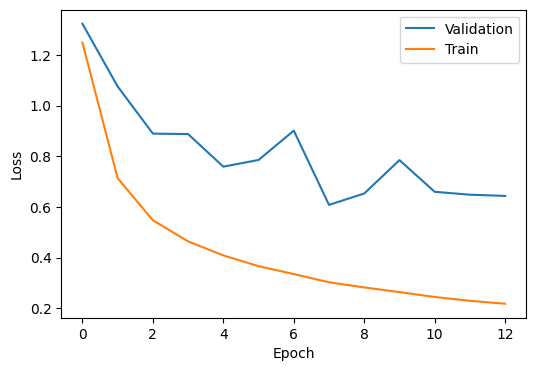

In [ ]:
baseline_1_log = pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_baseline1/baseline1_log.csv', sep=',')    
plt.style.use('default') 
plt.figure(figsize=(6,4))
plt.plot(baseline_1_log['epoch'], baseline_1_log['val_loss'])
plt.plot(baseline_1_log['epoch'], baseline_1_log['loss'])
plt.legend(['Validation', 'Train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')   

Balanced Accuracy: 0.8418
Accuracy: 0.7988


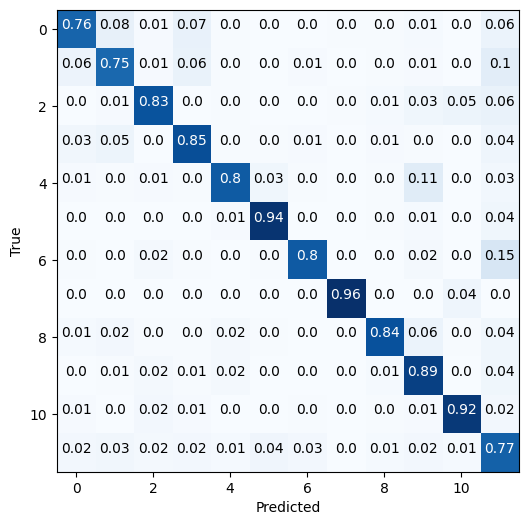

In [ ]:
baseline1_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline1/baseline1-08-0.61.hdf5')
avaliar_modelo(baseline1_best_model, test_generator_1, normalizado=True, num_classes=12)

**Modelo Baseline 2**:

*   Conjunto Silence do YouTube;
*   Sem aumentação.



Text(0.5, 0, 'Epoch')

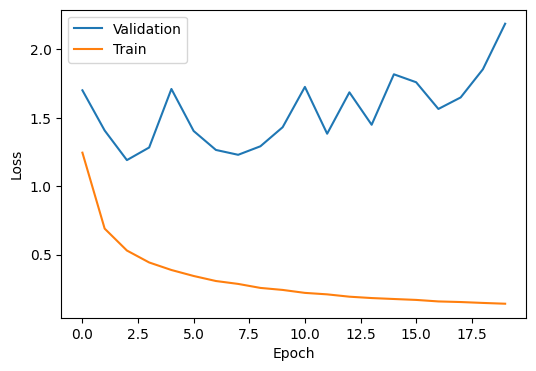

In [ ]:
baseline_2_log = pd.concat([pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/ger_baseline_mais_silencio_log.csv', sep=','),
                            pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/ger_baseline2_mais_silencio_cont_log.csv', sep=',')])


plt.style.use('default') 
plt.figure(figsize=(6,4))
plt.plot(baseline_2_log['epoch'], baseline_2_log['val_loss'])
plt.plot(baseline_2_log['epoch'], baseline_2_log['loss'])
plt.legend(['Validation', 'Train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')   

Balanced Accuracy: 0.7261
Accuracy: 0.6936


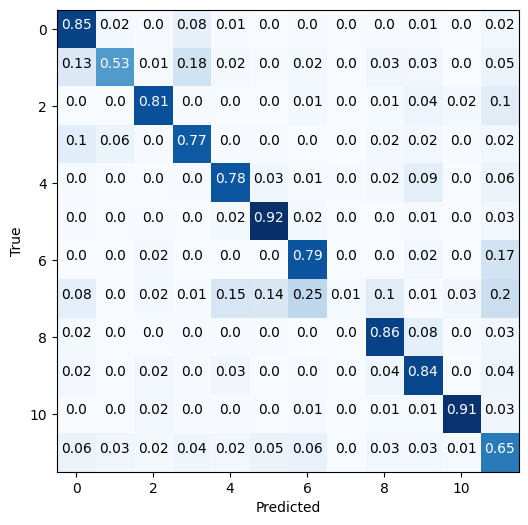

In [ ]:
baseline2_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/baseline_mais_silencio-02-1.01.hdf5')
avaliar_modelo(baseline2_best_model, test_generator_2, normalizado=True, num_classes=12)

**Modelo Baseline 3**:

*   Conjunto Silence do YouTube;
*   Com aumentação.


Text(0.5, 0, 'Epoch')

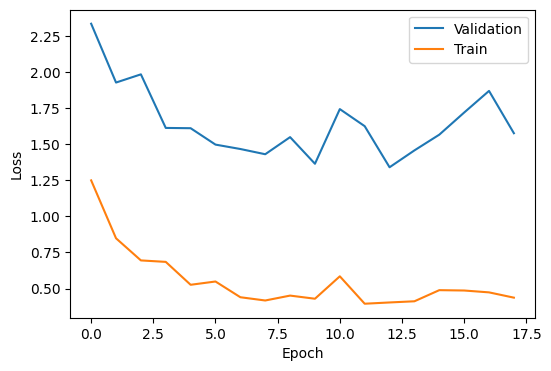

In [ ]:
baseline_3_log = pd.concat([pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio_log.csv', sep=','),
                            pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio_cont_log.csv', sep=','),
                            pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline3_mais_silencio_cont2_log.csv', sep=',')])
                            
plt.figure(figsize=(6,4))
plt.plot(baseline_3_log['epoch'], baseline_3_log['val_loss'])
plt.plot(baseline_3_log['epoch'], baseline_3_log['loss'])
plt.legend(['Validation', 'Train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')   

Balanced Accuracy: 0.6852
Accuracy: 0.7312


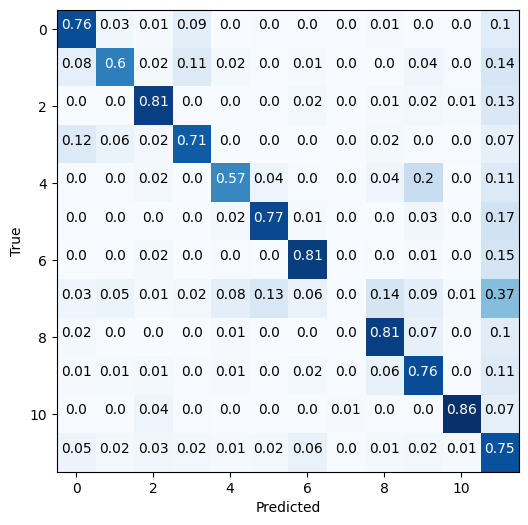

In [ ]:
baseline3_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline3_mais_silencio/gen_baseline_mais_silencio-13-1.34.hdf5')
avaliar_modelo(baseline3_best_model, test_generator_3, normalizado=True, num_classes=12)

Após os treinamentos conduzidos anteriormente, decidiu-se por retirar a aumentação de Pitch por aumentar consideravelmente o tempo de geração das imagens.

## **8. Análise dos Resultados**


Aqui serão avaliados os resultados do modelo Baseline 3 no conjunto de Validação.

In [ ]:
y_true = np.array(validation_generator_3.get_labels())
y_softmax = baseline3_best_model.predict(validation_generator_3)
y_pred = np.argmax(y_softmax, axis=1)

Avaliando as médias das probabilidades:

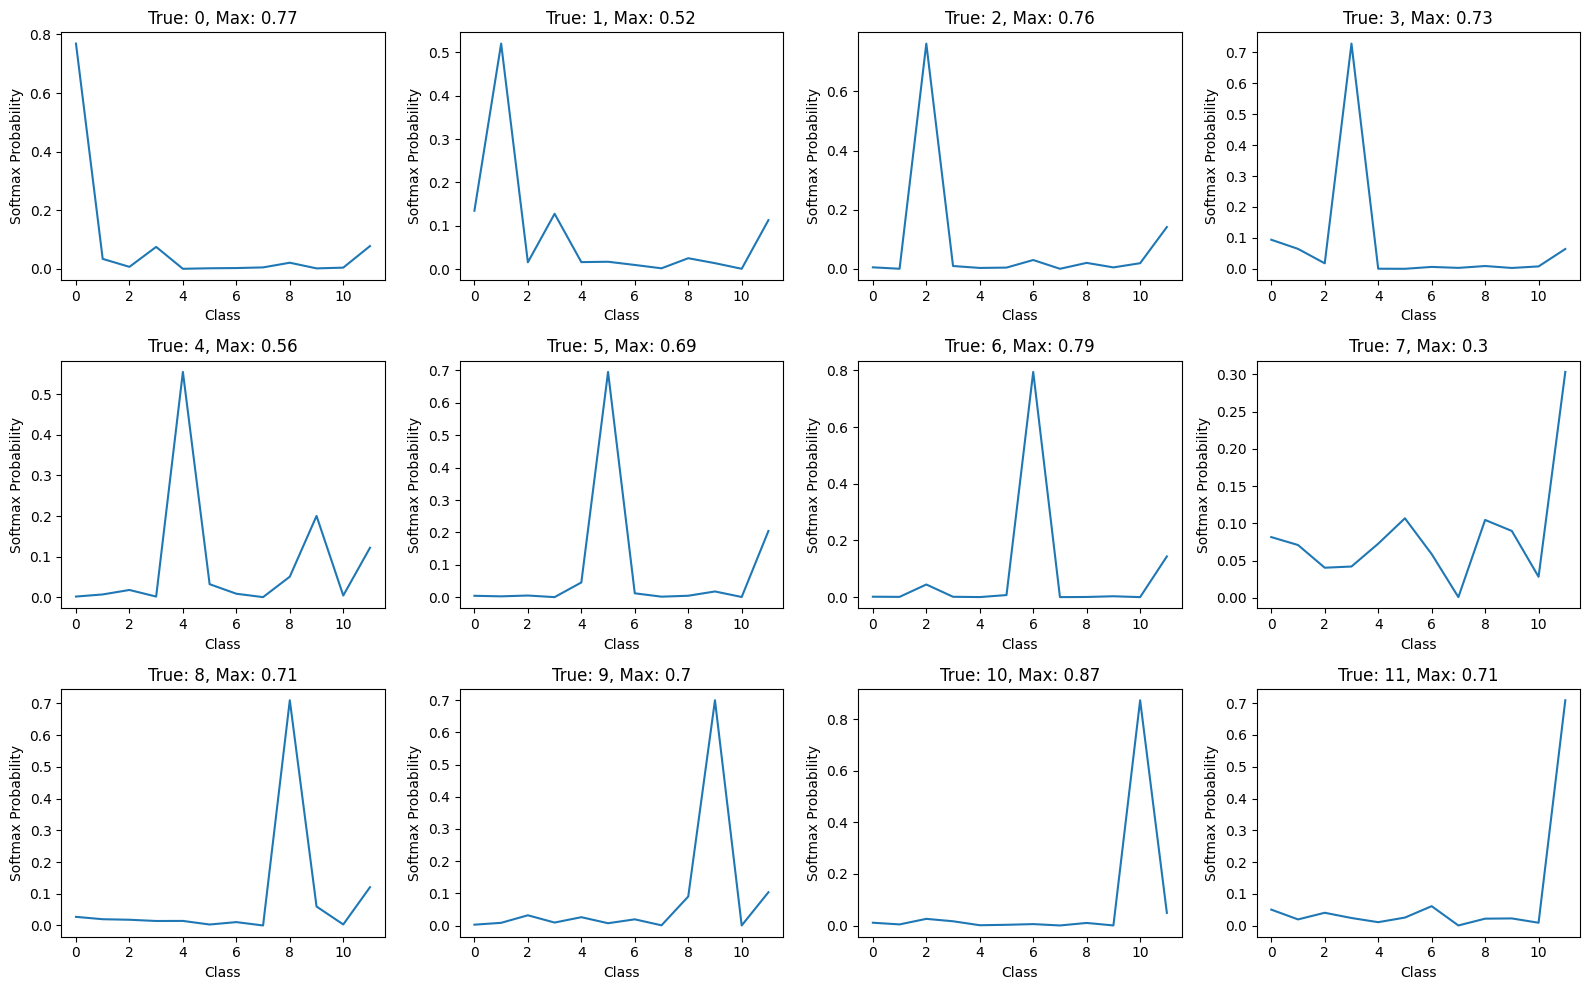

In [ ]:
index = np.full((12, len(y_true)), False)
for i in range(0,12):
  index[i,:] = y_true == i

class_prob = np.zeros((num_classes, num_classes))
for i in range(0,12):
  mtrx = np.asmatrix(y_softmax[index[i],])
  class_prob[i,] = mtrx.mean(axis=0)

plt.figure(figsize=(16,10))
for i in range(0,12):
  plt.subplot(3,4,i+1)
  plt.plot(class_prob[i,])
  plt.gca().set_title('True: '+str(i) + ', Max: '+str(round(max(class_prob[i,]),2)))
  plt.ylabel('Softmax Probability')
  plt.xlabel('Class')
  plt.tight_layout()

Balanced Accuracy: 0.7011
Accuracy: 0.7319


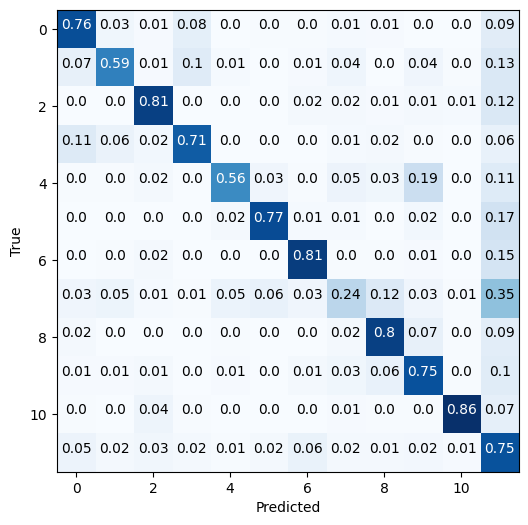

In [ ]:
avaliar_modelo_threshold(baseline3_best_model, test_generator_3, normalizado=True, num_classes=12, threshold = 0.4)

Avaliando o modelo Baseline 2:

Balanced Accuracy: 0.7255
Accuracy: 0.6754


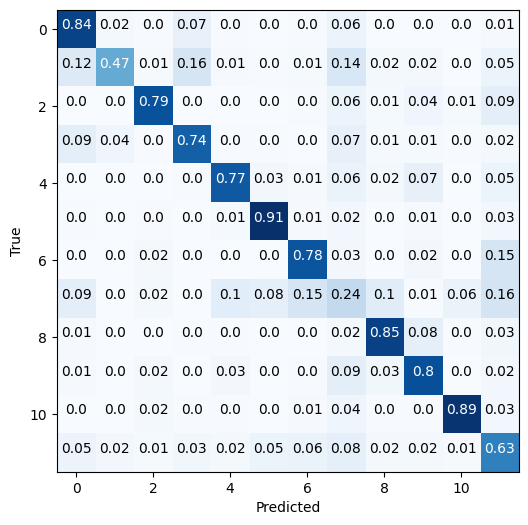

In [ ]:
baseline2_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_baseline2_mais_silencio/baseline_mais_silencio-02-1.01.hdf5')
avaliar_modelo_threshold(baseline2_best_model, test_generator_2, normalizado=True, num_classes=12, threshold = 0.4)

## **9. Modelos Complexos**


Utilizar aumentação em todos os casos.
Aumentação aplicada: apenas adição de ruído.

### **9.1 Rede VGG**

Treinando apenas a última camada:

In [ ]:
'''transfer_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(L, W, 3))'''

58892288/58889256 [==============================] - 2s 0us/step


Congelando a última camada

In [ ]:
'''# Congelando
for layer in transfer_model.layers:
    layer.trainable = False

# Acoplando o modelo VGG a uma camada convolucional (2 Camadas Dense)
full_model = tf.keras.Sequential([
  transfer_model,

  tf.keras.layers.GlobalAveragePooling2D(),

  tf.keras.layers.Dense(100, activation='relu') 
  
  tf.keras.layers.Dropout(0.2)

  tf.keras.layers.Dense(50, activation='relu') 

  tf.keras.layers.Dropout(0.2)

  tf.keras.layers.Dense(num_classes, activation='softmax')
])

full_model.summary()'''

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                6156      
Total params: 14,720,844
Trainable params: 6,156
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Definindo o Call Back
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_vgg/ger_vgg2_dense-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ger_vgg2_dense_log.csv', separator=",", append=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 9)

# Definindo o compilador
full_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

# Treinamento
full_model_history = full_model.fit(train_generator_3,             
                                epochs=40,
                                validation_data=validation_generator_3,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs, early_stopping])

Epoch 1/40
1461/1709 [========================>.....] - ETA: 4:09 - loss: 1.9411 - accuracy: 0.2477

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 1803s 1s/step - loss: 1.9033 - accuracy: 0.2554 - val_loss: 1.9028 - val_accuracy: 0.3301
Epoch 2/40
1709/1709 [==============================] - 1167s 683ms/step - loss: 1.6765 - accuracy: 0.2967 - val_loss: 1.9145 - val_accuracy: 0.3483
Epoch 3/40
1709/1709 [==============================] - 2045s 1s/step - loss: 1.4901 - accuracy: 0.3399 - val_loss: 1.9875 - val_accuracy: 0.2982
Epoch 4/40
1709/1709 [==============================] - 3059s 2s/step - loss: 1.3756 - accuracy: 0.3701 - val_loss: 1.9074 - val_accuracy: 0.3558
Epoch 5/40
1709/1709 [==============================] - 1021s 597ms/step - loss: 1.5784 - accuracy: 0.3157 - val_loss: 1.7691 - val_accuracy: 0.4047
Epoch 6/40
1709/1709 [==============================] - 1483s 868ms/step - loss: 1.3511 - accuracy: 0.3811 - val_loss: 1.8860 - val_accuracy: 0.3621
Epoch 7/40
1709/1709 [==============================] - 1238s 725ms/step - loss: 1.4120 - accuracy: 0.3655 - val_loss: 1.6932 

Text(0.5, 0, 'Epoch')

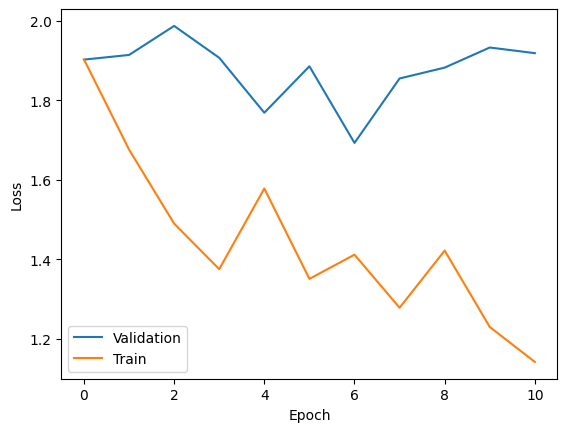

In [ ]:
# plotando curvas de Loss
vgg_results = pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_vgg/vgg2_dense_log.csv', sep=',')

plt.plot(vgg_results['epoch'],vgg_results['val_loss'])
plt.plot(vgg_results['epoch'],vgg_results['loss'])
plt.legend(['Validation', 'Train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

Balanced Accuracy: 0.2811
Accuracy: 0.4488


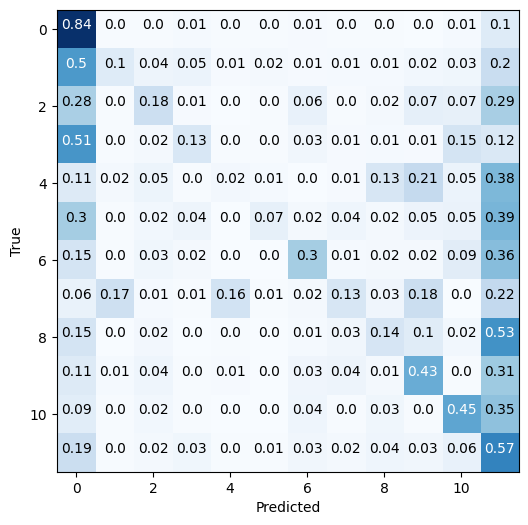

In [ ]:
vgg_dense_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_vgg/vgg2_dense-07-1.69.hdf5')
avaliar_modelo(vgg_dense_best_model, test_generator_3, normalizado=True, num_classes=12)

**Fine-tuning:**

In [ ]:
for layer in vgg_dense_best_model.layers:
    layer.trainable = True

vgg_dense_best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                6156      
Total params: 14,720,844
Trainable params: 14,720,844
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Definindo o Call Back
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_log.csv', separator=",", append=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 9)

# Definindo o compilador
vgg_dense_best_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

# Treinamento
vgg_dense_best_model_history = vgg_dense_best_model.fit(train_generator_3,             
                                epochs=40,
                                validation_data=validation_generator_3,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs, early_stopping])

In [ ]:
# Continuando o treinamento
vgg_ft_cont = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg-02-0.55.hdf5')

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_cont.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=False, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs_cont = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_log.csv', separator=",", append=False)
vgg_ft_cont_hist = vgg_ft_cont.fit(train_generator_3,             
                                epochs=10,
                                validation_data=validation_generator_3,
                                initial_epoch=2,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs_cont])

Epoch 3/10
1163/1709 [===================>..........] - ETA: 36:17 - loss: 0.1889 - accuracy: 0.9043

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 6811s 4s/step - loss: 0.1844 - accuracy: 0.9077 - val_loss: 0.3755 - val_accuracy: 0.8902
Epoch 4/10
1709/1709 [==============================] - 1138s 666ms/step - loss: 0.3646 - accuracy: 0.8252 - val_loss: 1.0546 - val_accuracy: 0.6889
Epoch 5/10
1709/1709 [==============================] - 1426s 834ms/step - loss: 0.2355 - accuracy: 0.8836 - val_loss: 0.5337 - val_accuracy: 0.8321
Epoch 6/10
1709/1709 [==============================] - 1507s 882ms/step - loss: 0.2067 - accuracy: 0.9015 - val_loss: 0.3731 - val_accuracy: 0.8912
Epoch 7/10
1709/1709 [==============================] - 4640s 3s/step - loss: 0.1176 - accuracy: 0.9413 - val_loss: 0.3333 - val_accuracy: 0.9040
Epoch 8/10
  40/1709 [..............................] - ETA: 1:16:07 - loss: 0.0886 - accuracy: 0.9398

Text(0.5, 0, 'Epoch')

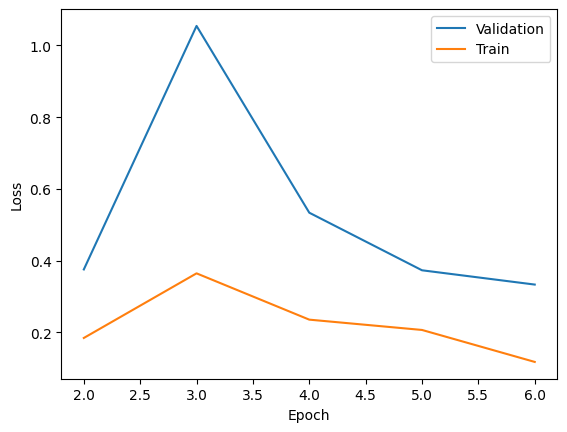

In [ ]:
# plotando curvas de Loss
vgg_ft_results = pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_log.csv', sep=',')

plt.plot(vgg_ft_results['epoch'],vgg_ft_results['val_loss'])
plt.plot(vgg_ft_results['epoch'],vgg_ft_results['loss'])
plt.legend(['Validation', 'Train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

### **9.2 Rede Convolucional**

In [ ]:
from tensorflow.keras import layers

complexo1 = tf.keras.Sequential()

# Conv 2D e Max Pooling
complexo1.add(layers.Conv2D(10, 3, padding='valid', input_shape=(L,W,n_channel)))
complexo1.add(layers.BatchNormalization(momentum=0.8))
complexo1.add(layers.ReLU())
complexo1.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
complexo1.add(layers.Conv2D(50, 3, padding='valid'))
complexo1.add(layers.BatchNormalization(momentum=0.8))
complexo1.add(layers.ReLU())
complexo1.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
complexo1.add(layers.Conv2D(100, 3, padding='valid'))
complexo1.add(layers.BatchNormalization(momentum=0.8))
complexo1.add(layers.ReLU())
complexo1.add(layers.MaxPooling2D(pool_size=(2,2)))

# Conv 2D e Max Pooling
complexo1.add(layers.Conv2D(150, 3, padding='valid'))
complexo1.add(layers.BatchNormalization(momentum=0.8))
complexo1.add(layers.ReLU())
complexo1.add(layers.MaxPooling2D(pool_size=(2,2)))

# Flatten
complexo1.add(layers.Flatten())

# Densa 1
complexo1.add(layers.Dense(100, activation='relu'))

# Dropout

complexo1.add(tf.keras.layers.Dropout(0.2))

# Densa 2
complexo1.add(layers.Dense(50, activation='relu'))

# Dense Final
complexo1.add(layers.Dense(num_classes, activation='softmax'))

complexo1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 126, 126, 10)      280       
_________________________________________________________________
batch_normalization_23 (Batc (None, 126, 126, 10)      40        
_________________________________________________________________
re_lu_23 (ReLU)              (None, 126, 126, 10)      0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 61, 61, 50)        4550      
_________________________________________________________________
batch_normalization_24 (Batc (None, 61, 61, 50)        200       
_________________________________________________________________
re_lu_24 (ReLU)              (None, 61, 61, 50)       

In [ ]:
'''# Definindo o Call Back
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_complexo1/complexo1-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_complexo1/complexo1_log.csv', separator=",", append=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 9)

# Definindo o compilador
complexo1.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

# Treinamento
complexo1_history = complexo1.fit(train_generator_3,             
                                epochs=40,
                                validation_data=validation_generator_3,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs, early_stopping])'''

Epoch 1/40
  87/1709 [>.............................] - ETA: 20:18 - loss: 3.6294 - accuracy: 0.1207

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


1709/1709 [==============================] - 1469s 860ms/step - loss: 2.0326 - accuracy: 0.1843 - val_loss: 2.0365 - val_accuracy: 0.2235
Epoch 2/40
1709/1709 [==============================] - 1697s 993ms/step - loss: 1.4532 - accuracy: 0.2770 - val_loss: 1.7253 - val_accuracy: 0.3589
Epoch 3/40
1709/1709 [==============================] - 2884s 2s/step - loss: 1.0997 - accuracy: 0.4646 - val_loss: 1.4079 - val_accuracy: 0.5477
Epoch 4/40
1709/1709 [==============================] - 2371s 1s/step - loss: 0.9307 - accuracy: 0.5441 - val_loss: 1.2880 - val_accuracy: 0.5837
Epoch 5/40
1709/1709 [==============================] - 1343s 786ms/step - loss: 0.9351 - accuracy: 0.5373 - val_loss: 1.3594 - val_accuracy: 0.5384
Epoch 6/40
1709/1709 [==============================] - 1285s 752ms/step - loss: 0.8819 - accuracy: 0.5452 - val_loss: 2.0435 - val_accuracy: 0.4331
Epoch 7/40
1709/1709 [==============================] - 2441s 1s/step - loss: 0.7140 - accuracy: 0.6187 - val_loss: 1.3574 

In [ ]:
'''# Continuando o treinamento
complexo1_cont = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_complexo1/complexo1-08-1.08.hdf5')

checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath = 'gdrive/My Drive/MDC2020/speech/train/callback_complexo1/cont_complexo1-{epoch:02d}-{val_loss:.2f}.hdf5',
                                                 monitor = 'val_loss',
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode = 'min')
training_logs_cont = tf.keras.callbacks.CSVLogger('gdrive/My Drive/MDC2020/speech/train/callback_complexo1/complexo1_cont_log.csv', separator=",", append=False)
complexo1_cont_h = complexo1_cont.fit(train_generator_3,             
                                epochs=40,
                                validation_data=validation_generator_3,
                                initial_epoch=8,
                                workers=8,
                                class_weight=class_weights,
                                callbacks = [checkpoints, training_logs_cont])'''

### **9.3 Avaliando os modelos no conjunto de Teste**

**Rede Convolucional**:

Text(0.5, 0, 'Epoch')

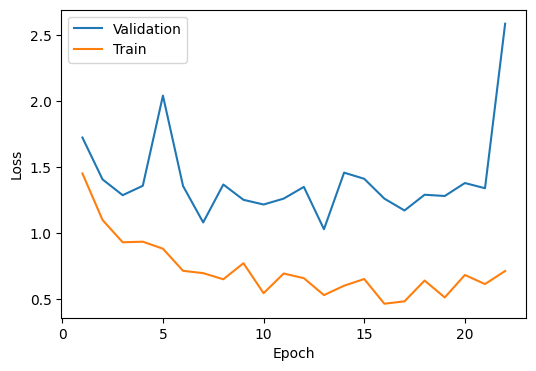

In [ ]:
rede_conv = pd.concat([pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_complexo1/complexo1_log.csv', sep=',')[1:8],
                            pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_complexo1/complexo1_cont_log.csv', sep=',')])
                            
plt.figure(figsize=(6,4))
plt.plot(rede_conv['epoch'], rede_conv['val_loss'])
plt.plot(rede_conv['epoch'], rede_conv['loss'])
plt.legend(['Validation', 'Train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')   

Balanced Accuracy: 0.7384
Accuracy: 0.6912


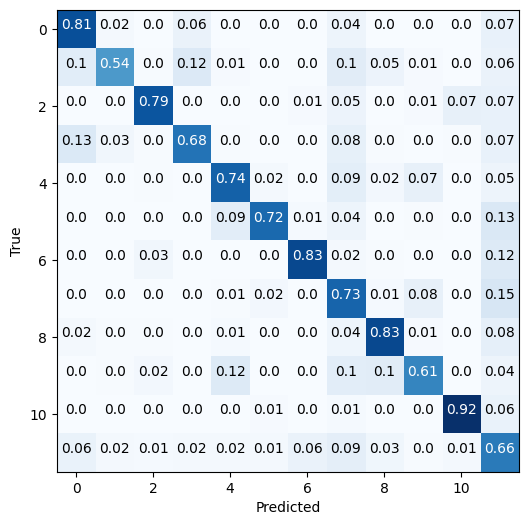

In [ ]:
rede_conv_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_complexo1/cont_complexo1-14-1.03.hdf5')
avaliar_modelo_threshold(rede_conv_best_model, test_generator_3, normalizado=True, num_classes=12, threshold=0.4)

**Rede VGG com fine-tuning**:

Text(0.5, 0, 'Epoch')

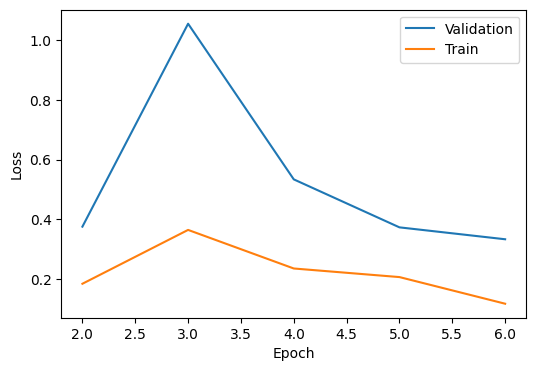

In [ ]:
rede_conv = pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_log.csv', sep=',')
                     #       pd.read_csv('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_log.csv', sep=',')])
                            
plt.figure(figsize=(6,4))
plt.plot(rede_conv['epoch'], rede_conv['val_loss'])
plt.plot(rede_conv['epoch'], rede_conv['loss'])
plt.legend(['Validation', 'Train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')   

Balanced Accuracy: 0.9142
Accuracy: 0.9289


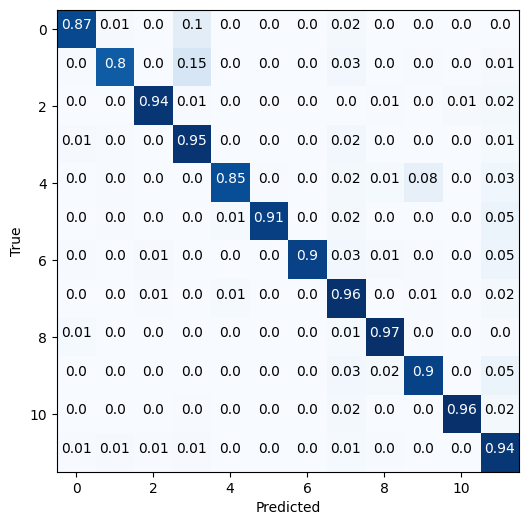

In [ ]:
vgg_tf_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_cont.hdf5')
avaliar_modelo_threshold(vgg_tf_best_model, test_generator_3, normalizado=True, num_classes=12, threshold=0.4)

# **10. Avaliando modelos no Kaggle**

In [ ]:
!p7zip -d --keep 'gdrive/My Drive/MDC2020/speech/test.7z'

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# melhor modelo
vgg_tf_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_vgg/ft_vgg_cont.hdf5')
baseline1_best_model = tf.keras.models.load_model('gdrive/My Drive/MDC2020/speech/train/callback_vgg/baseline1-08-0.61.hdf5')

# gerando o .csv
vgg_tf_csv = gerar_csv_kaggle(vgg_tf_best_model, 'test/audio/',class_dict, threshold=0.4)
baseline1_best_model_csv = gerar_csv_kaggle(baseline1_best_model, 'test/audio/',class_dict, threshold=0.4)

# salvando o .csv
vgg_tf_csv.to_csv('gdrive/My Drive/MDC2020/speech/vgg.csv', index=False)
baseline1_best_model_csv.to_csv('gdrive/My Drive/MDC2020/speech/baseline.csv', index=False)